<a href="https://colab.research.google.com/github/ehpub/KFQ_DL_2023-/blob/main/2023_kfq_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%98%A8%EB%8F%84_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 교재: https://www.gilbut.co.kr/book/view?bookcode=BN003496

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2023-07-24 07:18:40--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.236.152, 54.231.168.200, 52.217.224.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.236.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  56.1MB/s    in 0.2s    

2023-07-24 07:18:41 (56.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os

In [4]:
fname = os.path.join('jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

In [5]:
lines = data.split('\n')
print(len(lines))

420452


In [6]:
header = lines[0].split(',')
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
lines = lines[1:]

In [8]:
print(len(lines))

420451


In [9]:
import numpy as np

In [10]:
temperature = np.zeros((len(lines),))
temperature.shape

(420451,)

In [11]:
raw_data = np.zeros((len(lines),len(header)-1))
raw_data.shape

(420451, 14)

In [12]:
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:]

In [13]:
import matplotlib.pyplot as plt

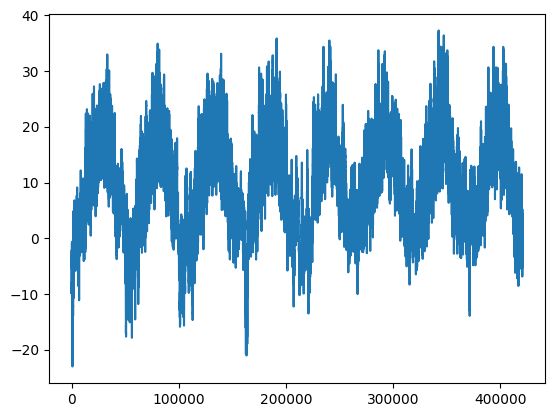

In [14]:
plt.plot(temperature)
plt.show()

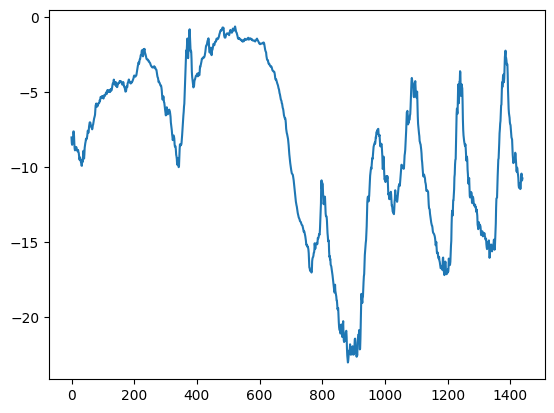

In [15]:
plt.plot(temperature[:1440])
plt.show()

In [16]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples -num_val_samples
num_train_samples, num_val_samples, num_test_samples

(210225, 105112, 105114)

In [17]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean #평균을 0으로 수평 이동
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std #z-score로 변환

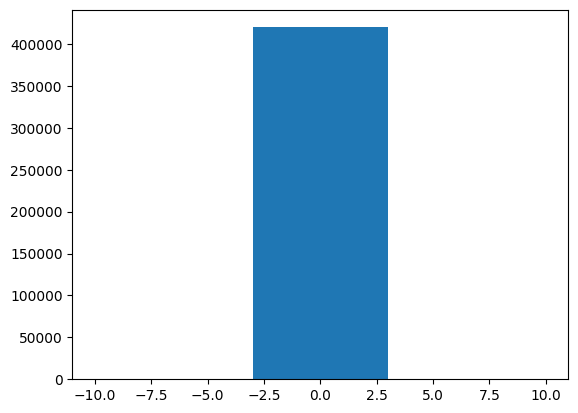

In [18]:
plt.hist(raw_data[:,1],bins=[-10,-3.5,-3,3,3.5,10])
plt.show()

In [19]:
raw_data[:,1].max(), raw_data[:,1].min()

(3.244116962984897, -3.62968450468683)

In [20]:
import numpy as np
from tensorflow import keras

In [21]:
int_sequence = np.arange(10)
int_sequence

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
period = 3
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence,
    targets = int_sequence[period*2:],
    sequence_length=period,
    sampling_rate=2
)
for inputs,target in dummy_dataset:
  print(inputs.shape, target.shape)

(4, 3) (4,)


In [23]:
inputs

<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
array([[0, 2, 4],
       [1, 3, 5],
       [2, 4, 6],
       [3, 5, 7]])>

In [24]:
target

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([6, 7, 8, 9])>

In [25]:
sampling_rate = 6
sequence_length = 120 #주기

In [26]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = temperature[sampling_rate*sequence_length+144:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    start_index = 0,
    end_index = num_train_samples,
    shuffle=True
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = temperature[sampling_rate*sequence_length+144:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    start_index = num_train_samples,
    end_index = num_train_samples +num_val_samples,
    shuffle=True
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-145],
    targets = temperature[sampling_rate*sequence_length+144:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    start_index = num_train_samples +num_val_samples,
    shuffle=True
)

In [71]:
def evaluate_native_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples,targets in dataset:
    try:
      preds = samples[:,-1,1]*std[1]+mean[1] #zscore를 온도로 변환
      total_abs_err += np.sum(np.abs(preds - targets))
      samples_seen += samples.shape[0]
    except:
      print('um')
      break
  return total_abs_err/samples_seen

In [72]:
print(evaluate_native_method(val_dataset))

2.550047129596812


In [73]:
print(evaluate_native_method(test_dataset))

2.736100239808155


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [77]:
raw_data.shape[-1]

14

In [75]:
for x,y in test_dataset:
  break
x.shape

TensorShape([128, 120, 14])

In [29]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

In [30]:
mcp= keras.callbacks.ModelCheckpoint('jena_dense.keras',
                                      save_best_only=True)

In [31]:
model.compile(loss='mse',metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [32]:
hist = model.fit(train_dataset,epochs=10,
                 validation_data = val_dataset,
                 callbacks=[mcp])

Epoch 1/10
1637/1637 [==============================] - 47s 27ms/step - loss: 11.5438 - mae: 2.6393 - val_loss: 12.1538 - val_mae: 2.7570
Epoch 2/10
1637/1637 [==============================] - 45s 27ms/step - loss: 8.6111 - mae: 2.3098 - val_loss: 12.6057 - val_mae: 2.8187
Epoch 3/10
1637/1637 [==============================] - 42s 26ms/step - loss: 7.9385 - mae: 2.2173 - val_loss: 11.0318 - val_mae: 2.6239
Epoch 4/10
1637/1637 [==============================] - 42s 25ms/step - loss: 7.5231 - mae: 2.1617 - val_loss: 12.1994 - val_mae: 2.7635
Epoch 5/10
1637/1637 [==============================] - 42s 26ms/step - loss: 7.2205 - mae: 2.1170 - val_loss: 11.5427 - val_mae: 2.6808
Epoch 6/10
1637/1637 [==============================] - 62s 38ms/step - loss: 7.0203 - mae: 2.0876 - val_loss: 11.6022 - val_mae: 2.6959
Epoch 7/10
1637/1637 [==============================] - 42s 25ms/step - loss: 6.8659 - mae: 2.0644 - val_loss: 11.0042 - val_mae: 2.6393
Epoch 8/10
1637/1637 [==================

In [27]:
model = keras.models.load_model('jena_dense.keras')
model.evaluate(test_dataset)

815/815 [==============================] - 18s 17ms/step - loss: 12.0085 - mae: 2.7280


[12.008506774902344, 2.7280004024505615]

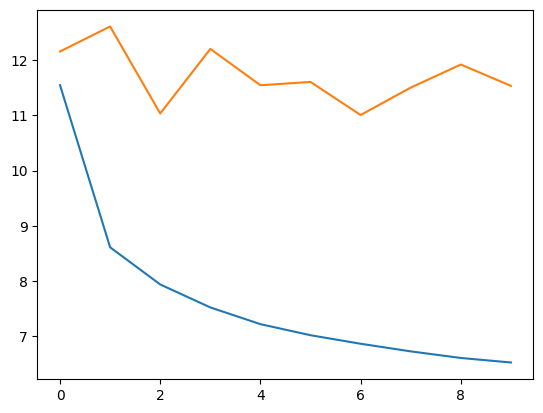

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

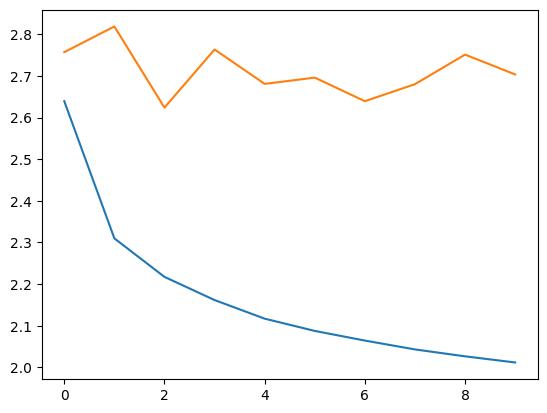

In [35]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.show()

## 컨브넷으로 시도

In [36]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8,24,activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,12,activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,6,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

In [37]:
mcp = keras.callbacks.ModelCheckpoint('jena_conv.keras',
                                      save_best_only=True)
model.compile(loss='mse',metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [38]:
hist = model.fit(train_dataset,
                 epochs=10,
                 validation_data=val_dataset,
                 callbacks=[mcp])

Epoch 1/10
1637/1637 [==============================] - 52s 27ms/step - loss: 19.0288 - mae: 3.4261 - val_loss: 16.1172 - val_mae: 3.2005
Epoch 2/10
1637/1637 [==============================] - 50s 31ms/step - loss: 13.8264 - mae: 2.9493 - val_loss: 17.3223 - val_mae: 3.2810
Epoch 3/10
1637/1637 [==============================] - 46s 28ms/step - loss: 12.6262 - mae: 2.8096 - val_loss: 18.0997 - val_mae: 3.3544
Epoch 4/10
1637/1637 [==============================] - 52s 32ms/step - loss: 11.8795 - mae: 2.7238 - val_loss: 16.7433 - val_mae: 3.2201
Epoch 5/10
1637/1637 [==============================] - 52s 32ms/step - loss: 11.3104 - mae: 2.6590 - val_loss: 23.1395 - val_mae: 3.8268
Epoch 6/10
1637/1637 [==============================] - 53s 33ms/step - loss: 10.8473 - mae: 2.6057 - val_loss: 16.2987 - val_mae: 3.1879
Epoch 7/10
1637/1637 [==============================] - 45s 27ms/step - loss: 10.4389 - mae: 2.5586 - val_loss: 16.1669 - val_mae: 3.1620
Epoch 8/10
1637/1637 [============

In [39]:
model = keras.models.load_model('jena_conv.keras')
model.evaluate(test_dataset)

815/815 [==============================] - 16s 19ms/step - loss: 17.1634 - mae: 3.3061


[17.163406372070312, 3.3061375617980957]

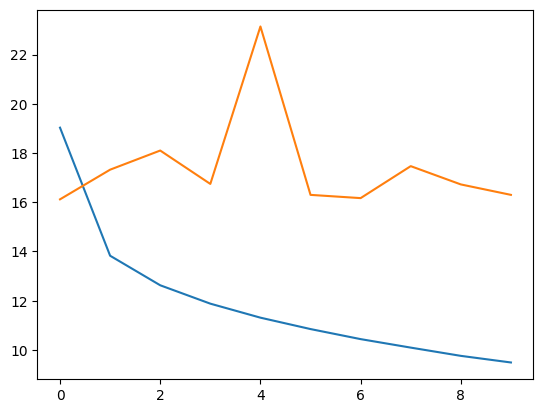

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

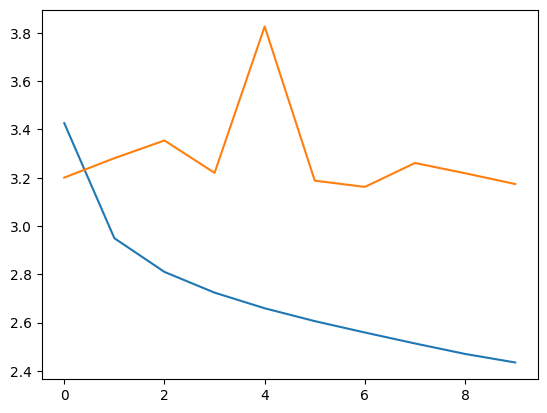

In [41]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1637/1637 [==============================] - 53s 31ms/step - loss: 29.2574 - mae: 3.8671 - val_loss: 10.4360 - val_mae: 2.5291
Epoch 2/10
1637/1637 [==============================] - 49s 30ms/step - loss: 10.4766 - mae: 2.5302 - val_loss: 10.5466 - val_mae: 2.5297
Epoch 3/10
1637/1637 [=======================

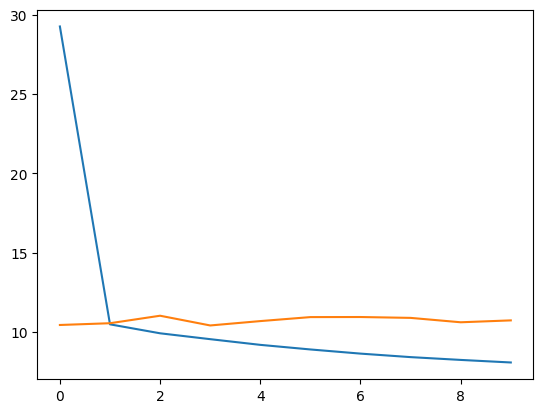

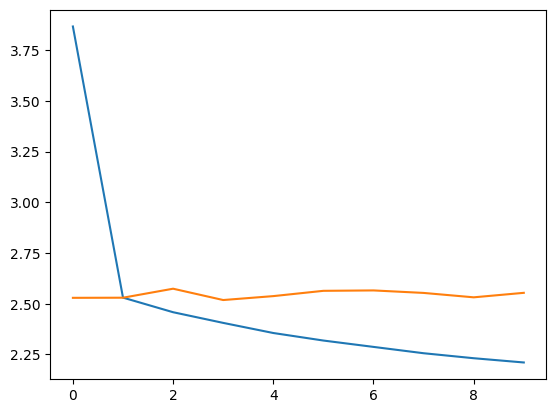

In [43]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
mcp = keras.callbacks.ModelCheckpoint('jena_lstm.keras',
                                      save_best_only=True)
model.compile(loss='mse',metrics=['mae'])
model.summary()
hist = model.fit(train_dataset,
                 epochs=10,
                 validation_data=val_dataset,
                 callbacks=[mcp])
model = keras.models.load_model('jena_lstm.keras')
model.evaluate(test_dataset)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.show()

In [44]:
model = keras.models.load_model('jena_lstm.keras')
model.evaluate(test_dataset)

815/815 [==============================] - 16s 20ms/step - loss: 11.5246 - mae: 2.6733


[11.524649620056152, 2.6733438968658447]

In [45]:
import numpy as np

In [49]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps,input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features,input_features))
U = np.random.random((output_features,output_features))
b = np.random.random((output_features))

successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W,input_t) + np.dot(U,state_t)+b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs,axis=0)
final_output_sequence.shape

(100, 64)

In [50]:
num_features = 14
inputs = keras.Input(shape=(None,num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [51]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps,num_features))
outputs = layers.SimpleRNN(16,return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [52]:
inputs = keras.Input(shape=(steps,num_features))
x = layers.SimpleRNN(16,return_sequences=True)(inputs)
x = layers.SimpleRNN(16,return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
print(outputs.shape)

(None, 16)


## 순환 드랍아웃 사용하기

In [32]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.LSTM(32,recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

mcp = keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',
                                      save_best_only=True)
model.compile(loss='mse',metrics=['mae'])
hist = model.fit(train_dataset,
                 epochs=50,
                 validation_data=val_dataset,
                 callbacks=[mcp])

Epoch 1/2
1637/1637 [==============================] - 336s 203ms/step - loss: 22.6638 - mae: 3.5730 - val_loss: 10.0137 - val_mae: 2.4553
Epoch 2/2
1637/1637 [==============================] - 329s 201ms/step - loss: 14.7240 - mae: 2.9787 - val_loss: 10.1466 - val_mae: 2.4728


In [28]:
model = keras.models.load_model('jena_lstm_dropout.keras')
model.evaluate(test_dataset)

815/815 [==============================] - 42s 50ms/step - loss: 11.5094 - mae: 2.6768


[11.509407997131348, 2.6768054962158203]

In [31]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.GRU(32,recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32,recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

mcp = keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras',
                                      save_best_only=True)
model.compile(loss='mse',metrics=['mae'])
hist = model.fit(train_dataset,
                 epochs=50,
                 validation_data=val_dataset,
                 callbacks=[mcp])

Epoch 1/2
1637/1637 [==============================] - 601s 364ms/step - loss: 20.3109 - mae: 3.3816 - val_loss: 9.2526 - val_mae: 2.3665
Epoch 2/2
1637/1637 [==============================] - 579s 354ms/step - loss: 13.6433 - mae: 2.8690 - val_loss: 9.2657 - val_mae: 2.3715


In [29]:
model = keras.models.load_model('jena_stacked_gru_dropout.keras')
model.evaluate(test_dataset)

815/815 [==============================] - 69s 84ms/step - loss: 10.6295 - mae: 2.5589


[10.629505157470703, 2.5589022636413574]